In [1]:
library(dplyr)
library(monocle3)
library(cluster)
library(ggplot2)
library(leidenbase)
library(FastKNN)
library(distances)
library(FNN)
library(dbscan)
library(Rcpp)
library(igraph)
options(repr.plot.width=20, repr.plot.height=8)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, i

In [2]:
# Load clustering information: silhouette avg widths, coherence scores, number of clusters etc.
Monocle3PW_info_sil = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P3_Proposed_workflow/PW_files/monocle3PW_jobs_silhouette.csv")
Monocle3PW_info_sil$X = NULL

Monocle3PW_info_coh = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P3_Proposed_workflow/PW_files/Monocle3PW_coherence_summary_jobs.csv")
Monocle3PW_info_coh$X = NULL

Monocle3PW_info_coh["avg_widths"] = Monocle3PW_info_sil["avg_widths"]
Monocle3PW_info = Monocle3PW_info_coh

In [3]:
Monocle3PW_info

k_range,avg_coherence,num_cluster,avg_widths
<int>,<dbl>,<int>,<dbl>
5,0.11142446,41,0.2713104
6,0.10914612,28,0.2265528
7,0.11711847,21,0.2593242
8,0.13196021,19,0.2903283
9,0.12458771,15,0.3356689
10,0.12914869,14,0.3123870
11,0.12246844,13,0.3491630
12,0.12541373,10,0.4187658
13,0.11941652,9,0.4215938


In [4]:
# Load evaluation metrics
Monocle3_eva = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P3_Proposed_workflow/PW_files/Monocle3PW_evaluation_metrics_jobs.csv")
LDA_eva = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P2_scRNAseq_LDA_NMF/LDA_NMF/LDA_NMF_files/LDA_jobs_evaluation_metrics_raw_stemming.csv")
NMF_eva = read.csv("/home/rep/scRNA-seq_clustering_to_Twitter/P2_scRNAseq_LDA_NMF/LDA_NMF/LDA_NMF_files/NMF_jobs_evaluation_metrics_raw_stemming.csv")
Monocle3_eva$X = NULL
LDA_eva$X =NULL
NMF_eva$X = NULL

In [5]:
# Combine and organize all information 
Monocle3_PW = cbind(Monocle3PW_info, Monocle3_eva) %>% mutate(method = rep("Monocle3_based_workflow",nrow(Monocle3_eva))) %>% select(-avg_coherence, -avg_widths, -k_range)
LDA = LDA_eva %>% mutate(method = rep("LDA",nrow(LDA_eva)))
NMF = NMF_eva %>% mutate(method = rep("NMF",nrow(NMF_eva)))

Final_df = rbind(Monocle3_PW, LDA, NMF)

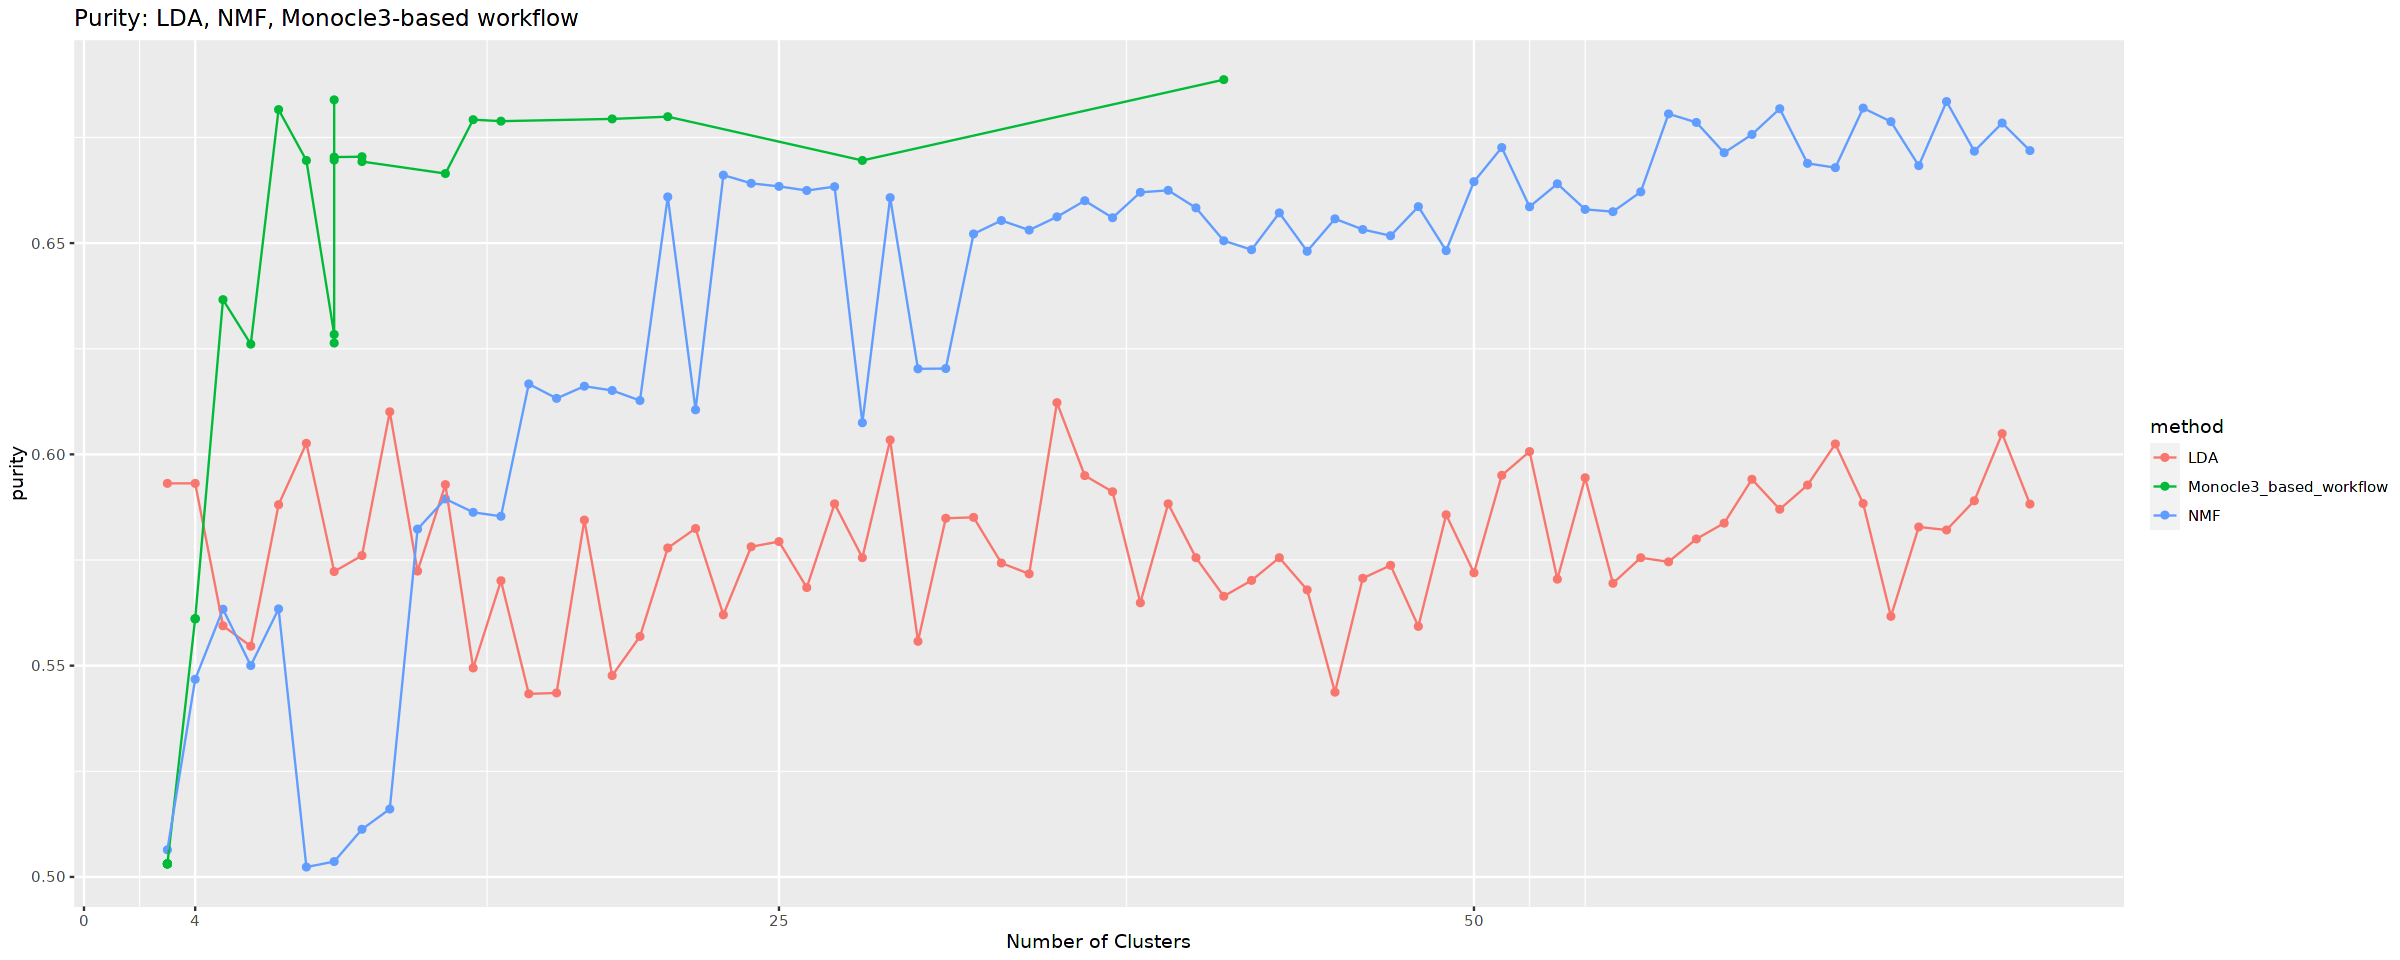

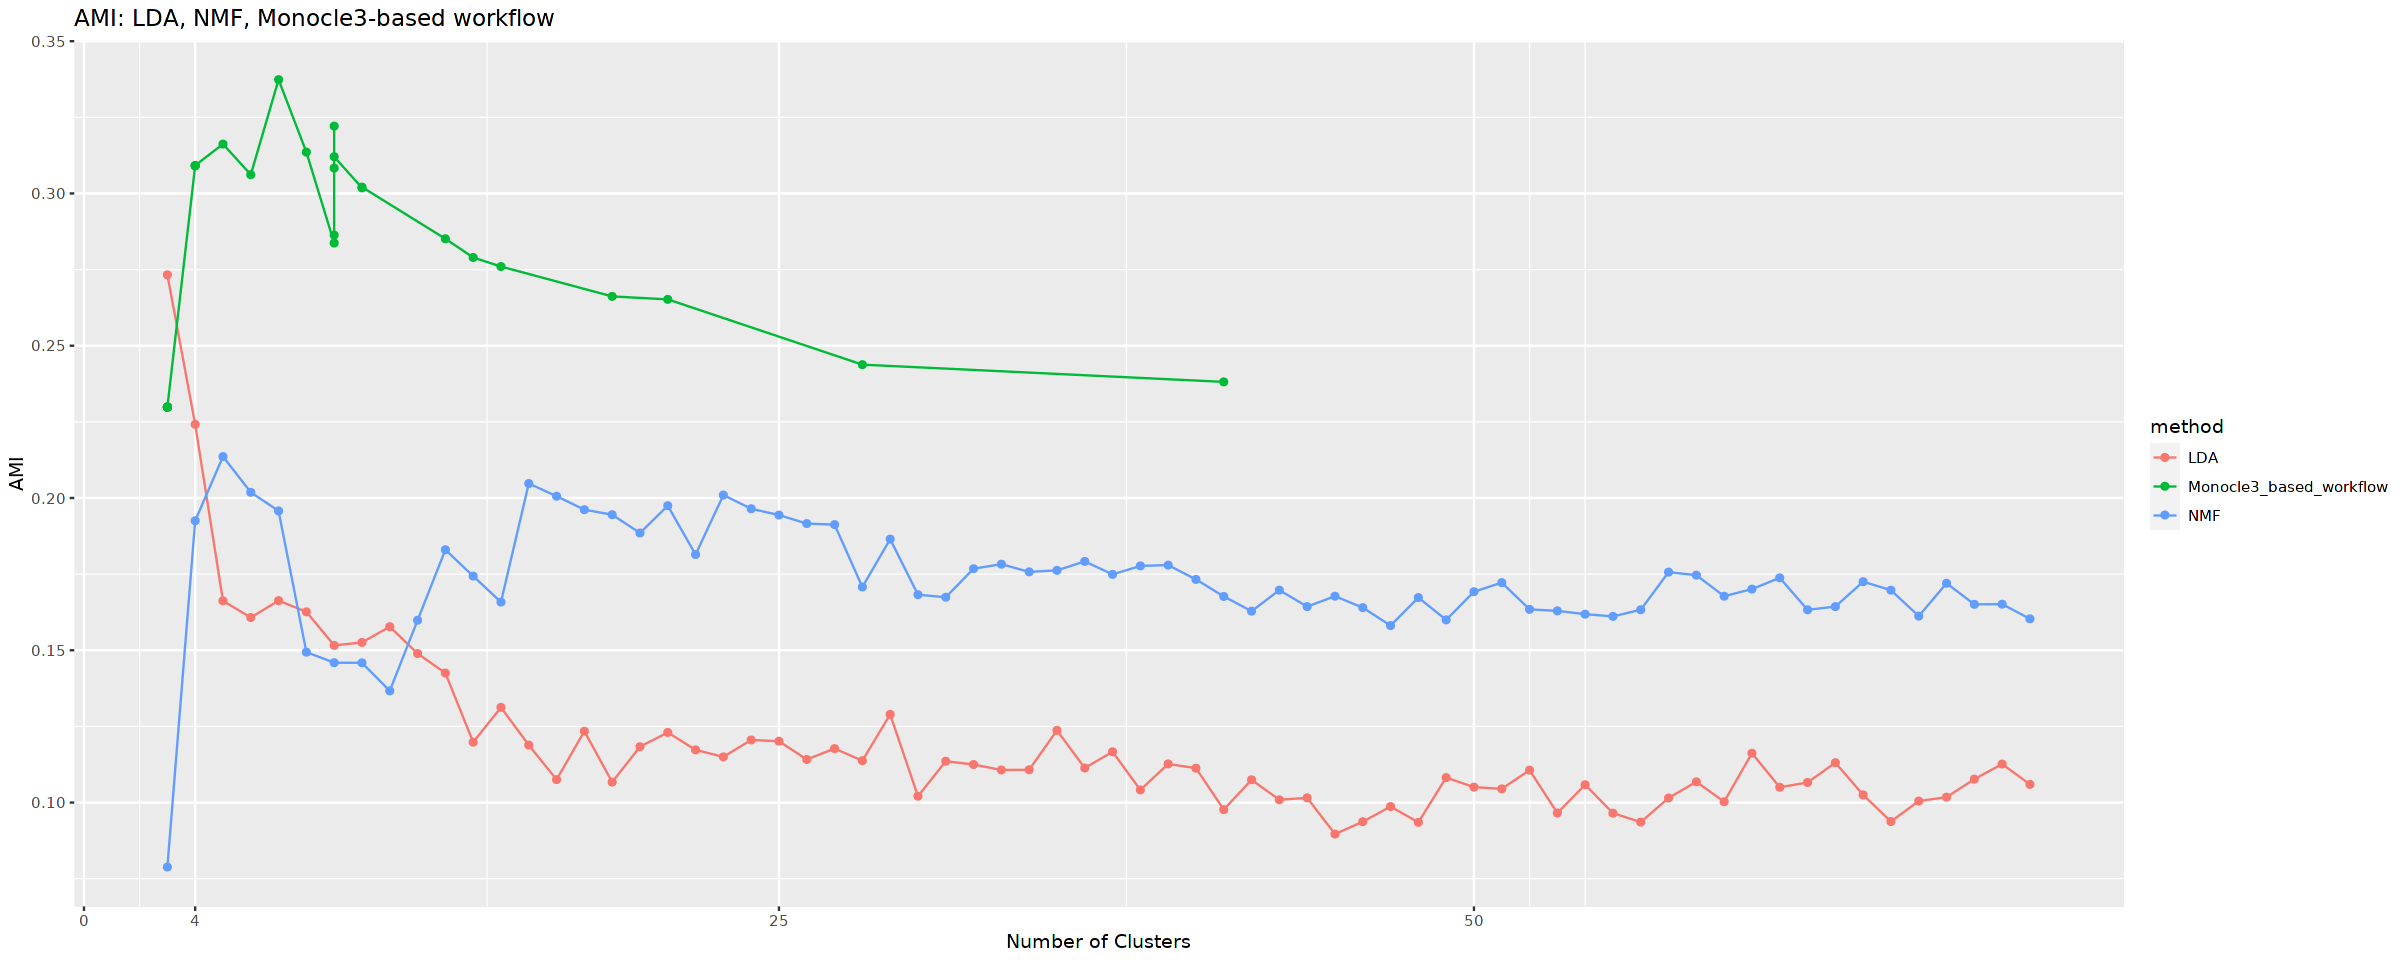

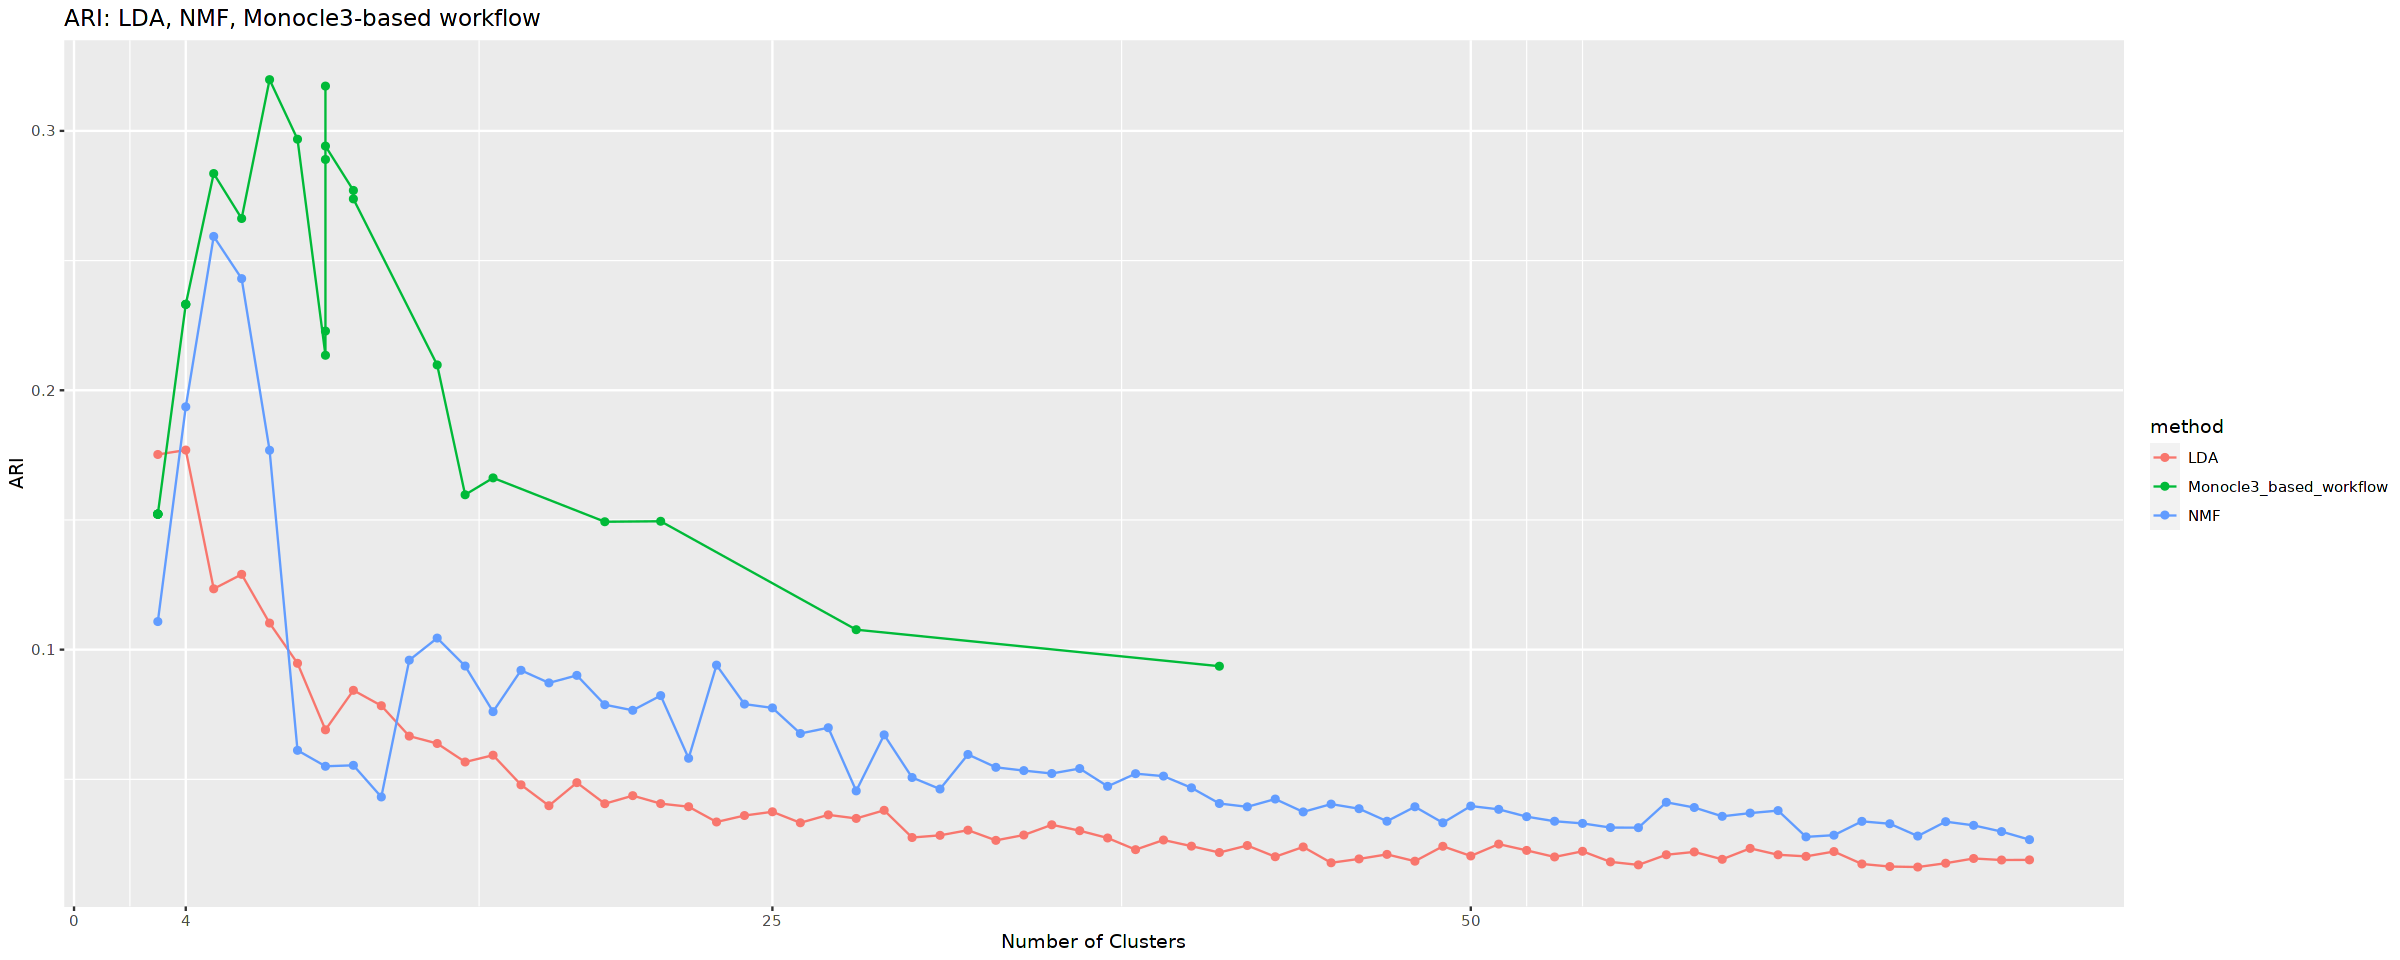

In [6]:
################
## (1) Purity ##
################
Final_df %>% ggplot(aes(x = num_cluster, y = Purity, color = method)) + 
  geom_point() + geom_line() +
  ggtitle("Purity: LDA, NMF, Monocle3-based workflow") +  
  scale_x_continuous(name="Number of Clusters", breaks=c(0, 4, 25, 50, 75, 100)) +
  scale_y_continuous(name="purity") 

ggsave("P2_plots/purity_jobs.png",  width = 35, height = 12, units = "cm")

#############
## (2) AMI ##
#############
Final_df %>% ggplot(aes(x = num_cluster, y = AMI, color = method)) + 
  geom_point() + geom_line() +
  ggtitle("AMI: LDA, NMF, Monocle3-based workflow") +  
  scale_x_continuous(name="Number of Clusters", breaks=c(0, 4, 25, 50, 75, 100)) +
  scale_y_continuous(name="AMI") 

ggsave("P2_plots/AMI_jobs.png",  width = 35, height = 12, units = "cm")

#############
## (3) ARI ##
#############
Final_df %>% ggplot(aes(x = num_cluster, y = ARI, color = method)) + 
  geom_point() + geom_line() +
  ggtitle("ARI: LDA, NMF, Monocle3-based workflow") +  
  scale_x_continuous(name="Number of Clusters", breaks=c(0, 4, 25, 50, 75, 100)) +
  scale_y_continuous(name="ARI") 

ggsave("P2_plots/ARI_jobs.png",  width = 35, height = 12, units = "cm")